In [1]:
import xarray as xr
import rasterio
import rioxarray
import os
import pystac_client
import json
import pandas as pd
import odc.stac
import planetary_computer
import geopandas as gpd
from shapely.geometry import shape
import numpy as np
import matplotlib.pyplot as plt

In [2]:
aoi = {
        "type": "Polygon",
        "coordinates": [
            [[-121.85308124466923,46.94373134954458],
            [-121.85308124466923,46.785391494446145],
            [-121.63845508457872,46.785391494446145],
            [-121.63845508457872,46.94373134954458],
            [-121.85308124466923,46.94373134954458]]]
    }

In [3]:
aoi_gpd = gpd.GeoDataFrame({'geometry':[shape(aoi)]}).set_crs(crs="EPSG:4326")
crs = aoi_gpd.estimate_utm_crs()

In [4]:
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

In [5]:
search = stac.search(
    intersects=aoi,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}})

items = search.item_collection()

In [6]:
s2_ds = odc.stac.load(items,chunks={"x": 2048, "y": 2048},
                      bbox=aoi_gpd.total_bounds,
                      groupby='solar_day').where(lambda x: x > 0, other=np.nan)
print(f"Returned {len(s2_ds.time)} acquisitions")

Returned 443 acquisitions


In [7]:
total_pixels = len(s2_ds.y)*len(s2_ds.x)
nan_count = (~np.isnan(s2_ds.B08)).sum(dim=['x', 'y']).compute()

In [8]:
s2_ds = s2_ds.where(nan_count >= total_pixels*0.9, drop=True)

In [15]:
s2_ds_snowoff = s2_ds.where((s2_ds.time.dt.month >= 7) & (s2_ds.time.dt.month <= 10), drop=True)

In [16]:
s2_ds_snowoff.time

<xarray.DataArray 'time' (time: 72)> Size: 576B
array(['2016-07-27T18:59:22.026000000', '2016-09-25T19:01:22.026000000',
       '2017-07-02T18:59:21.026000000', '2017-07-17T18:59:19.027000000',
       '2017-07-22T18:59:21.026000000', '2017-08-26T18:59:09.027000000',
       '2017-09-15T19:00:09.027000000', '2017-09-28T19:11:39.027000000',
       '2017-10-05T19:02:29.027000000', '2017-10-30T19:05:21.026000000',
       '2018-07-12T18:59:19.024000000', '2018-07-17T18:59:21.024000000',
       '2018-07-22T18:59:19.024000000', '2018-07-27T18:59:21.024000000',
       '2018-08-06T18:59:21.024000000', '2018-08-21T18:59:09.024000000',
       '2018-09-05T18:59:11.024000000', '2018-10-15T19:03:41.024000000',
       '2019-07-22T18:59:21.024000000', '2019-08-01T18:59:21.024000000',
       '2019-08-26T18:59:19.024000000', '2019-10-10T19:03:11.024000000',
       '2019-10-30T19:05:21.024000000', '2020-07-16T18:59:21.024000000',
       '2020-07-21T18:59:19.024000000', '2020-07-26T18:59:21.024000000',
       '2020-07-31T18:59:19.024000000', '2020-08-05T18:59:21.024000000',
       '2020-08-10T18:59:19.024000000', '2020-08-15T18:59:21.024000000',
       '2020-08-25T18:59:21.024000000', '2020-08-30T18:59:19.024000000',
       '2020-09-04T18:59:21.024000000', '2020-09-09T18:59:29.024000000',
       '2020-09-29T19:01:09.024000000', '2021-07-06T18:59:19.024000000',
       '2021-07-11T18:59:21.024000000', '2021-07-26T18:59:19.024000000',
       '2021-08-15T18:59:19.024000000', '2021-08-25T18:59:19.024000000',
       '2021-09-24T19:00:29.024000000', '2022-07-11T18:59:19.024000000',
       '2022-07-21T18:59:19.024000000', '2022-07-26T18:59:31.024000000',
       '2022-07-31T18:59:19.024000000', '2022-08-15T18:59:31.024000000',
       '2022-08-25T18:59:31.024000000', '2022-08-30T18:59:19.024000000',
       '2022-09-09T18:59:29.024000000', '2022-09-19T19:00:49.024000000',
       '2022-09-24T19:01:31.024000000', '2022-10-19T19:04:19.024000000',
       '2023-07-01T18:59:21.024000000', '2023-07-06T18:59:19.024000000',
       '2023-07-21T18:59:21.024000000', '2023-07-26T18:59:19.024000000',
       '2023-07-31T18:59:21.024000000', '2023-08-15T18:59:19.024000000',
       '2023-08-20T18:59:21.024000000', '2023-08-25T18:59:19.024000000',
       '2023-09-09T18:59:41.024000000', '2023-09-14T19:00:19.024000000',
       '2023-10-19T19:04:11.024000000', '2023-10-29T19:05:11.024000000',
       '2024-07-05T18:59:21.024000000', '2024-07-10T18:59:19.024000000',
       '2024-07-15T18:59:21.024000000', '2024-07-20T18:59:19.024000000',
       '2024-08-04T18:59:21.024000000', '2024-08-29T18:59:19.024000000',
       '2024-10-03T19:02:31.024000000', '2024-10-13T19:03:41.024000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 576B 2016-07-27T18:59:22.026000 ... 20...

In [27]:
# period_index = pd.PeriodIndex(s2_ds_snowoff['time'].values, freq='M')
# s2_ds_snowoff.coords['year_month'] = ('time', period_index)
# first_image_indices = s2_ds_snowoff.groupby('year_month').apply(lambda x: x.isel(time=0))

In [17]:
image_dates = s2_ds_snowoff.time.dt.strftime('%Y-%m-%d').values.tolist()

In [19]:
image_dates[0]

'2016-07-27'

In [38]:
npairs = 5

In [39]:
pairs = []
for r in range(len(s2_ds_snowoff.time) - npairs):
    for s in range(1, npairs + 1 ):
        t_baseline = s2_ds_snowoff.isel(time=r+s).time - s2_ds_snowoff.isel(time=r).time
        if t_baseline.dt.days <= 100:
            img1_date = image_dates[r]
            img2_date = image_dates[r+s]
            shortname = f'{img1_date}_{img2_date}'
            pairs.append({'img1_date': img1_date, 'img2_date': img2_date, 'name':shortname})
#matrixJSON = f'{{"include":{json.dumps(pairs)}}}'
print(f'Number of Pairs: {len(pairs)}')

# with open(os.environ['GITHUB_OUTPUT'], 'a') as f:
#     print(f'BURST_IDS={image_dates}', file=f)
#     print(f'MATRIX_PARAMS_COMBINATIONS={matrixJSON}', file=f)

Number of Pairs: 221


In [34]:
t_baseline.dt.days

<xarray.DataArray 'days' ()> Size: 8B
array(70)
Coordinates:
    spatial_ref  int32 4B 32610

# search for individual dates

In [29]:
date1 = image_dates[0]
date2 = image_dates[1]

In [37]:
date2

'2016-09-25'

In [31]:
search = stac.search(
    intersects=aoi,
    datetime=image_dates[0],
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 10}})

In [32]:
items = search.item_collection()

In [33]:
s2_ds = odc.stac.load(items,chunks={"x": 2048, "y": 2048},
                      bbox=aoi_gpd.total_bounds,
                      groupby='solar_day',
                     ).where(lambda x: x > 0, other=np.nan)
print(f"Returned {len(s2_ds.time)} acquisitions")

Returned 1 acquisitions


In [35]:
s2_ds

<xarray.Dataset> Size: 190MB
Dimensions:      (time: 1, y: 1787, x: 1665)
Coordinates:
  * y            (y) float64 14kB 5.2e+06 5.2e+06 ... 5.182e+06 5.182e+06
  * x            (x) float64 13kB 5.873e+05 5.873e+05 ... 6.039e+05 6.039e+05
    spatial_ref  int32 4B 32610
  * time         (time) datetime64[ns] 8B 2016-07-27T18:59:22.026000
Data variables: (12/16)
    AOT          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B01          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B02          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B03          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B04          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B05          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B12          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    B8A          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    SCL          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    WVP          (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>
    visual       (time, y, x) float32 12MB dask.array<chunksize=(1, 1787, 1665), meta=np.ndarray>

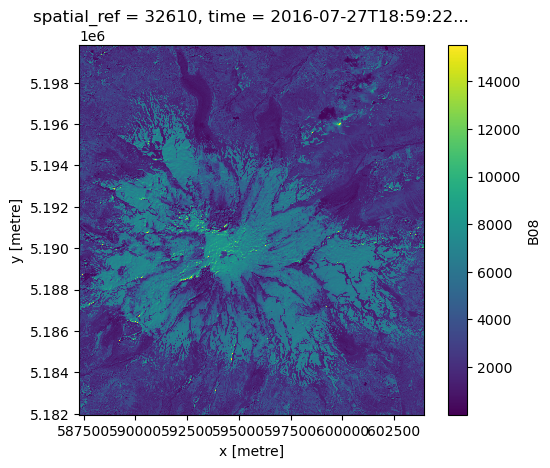

In [34]:
f, ax = plt.subplots()
s2_ds.B08.squeeze().plot.imshow()
ax.set_aspect('equal')

In [ ]:
def download_s2(img1_product_name, img2_product_name, bbox):
    '''
    Download a pair of Sentinel-2 images acquired on given dates over a given bounding box
    '''
    # We use the api from element84 to query the data
    URL = "https://earth-search.aws.element84.com/v1"
    catalog = pystac_client.Client.open(URL)

    search = catalog.search(
    collections=["sentinel-2-l2a"],
    query=[f's2:product_uri={img1_product_name}'])
    
    img1_items = search.item_collection()
    img1_full = stackstac.stack(img1_items)

    search = catalog.search(
    collections=["sentinel-2-l2a"],
    query=[f's2:product_uri={img2_product_name}'])

    # Check how many items were returned
    img2_items = search.item_collection()
    img2_full = stackstac.stack(img2_items)

    aoi = gpd.GeoDataFrame({'geometry':[shape(bbox)]})
    # crop images to aoi
    img1_clipped = img1_full.rio.clip_box(*aoi.total_bounds,crs=4326) 
    img2_clipped = img2_full.rio.clip_box(*aoi.total_bounds,crs=4326)
    
    img1_ds = img1_clipped.to_dataset(dim='band')
    img2_ds = img2_clipped.to_dataset(dim='band')

    return img1_ds, img2_ds

In [45]:
dates = 'S2_2019-10-10_2019-11-29_horizontal_velocity.tif'[3:24]

In [52]:
from datetime import datetime

In [53]:
datetime.strptime(dates[11:], '%Y-%m-%d')

datetime.datetime(2019, 11, 29, 0, 0)